In [1]:
import numpy as np
from scipy.optimize import minimize

import matplotlib.pyplot as plt
#%matplotlib inline

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



import tresonator as T

#import skrf as rf
#rf.stylely()

## S11 vs Frequency 

In [3]:
fs = 1e6*np.linspace(61, 64, 301)
P_in = 20e3 # W

@interact(Lsc_DUT=(20, 60, 0.1), Lsc_CEA=(1, 200, 0.1), 
          Z_DUT=(1, 1e2, 0.1), Z_CEA=(1, 1e2, 0.1), 
          add_loss=(0.1, 5, 0.1))
def S11_vf_f(Lsc_DUT=33, Lsc_CEA=32, 
             Z_DUT = 6, Z_CEA = 6,
             add_loss=1.0):
    S11dB = []
    for f in fs:
        _cfg = T.Configuration(f, P_in, Lsc_DUT*1e-3, Lsc_CEA*1e-3, 
                               Z_short_DUT = Z_DUT*1e-3, Z_short_CEA = Z_CEA*1e-3, 
                               additional_losses=add_loss)
        S11dB.append(_cfg.S11dB())
    fig,ax=plt.subplots()
    ax.plot(fs/1e6, S11dB, lw=2)
    ax.grid(True)
    ax.set_ylim(-40,0)
    ax.set_xlabel('f [MHz]', fontsize=14)
    ax.set_ylabel('S11 [dB]', fontsize=14)

interactive(children=(FloatSlider(value=33.0, description='Lsc_DUT', max=60.0, min=20.0), FloatSlider(value=32.0, description='Lsc_CEA', max=200.0, min=1.0), FloatSlider(value=6.0, description='Z_DUT', min=1.0), FloatSlider(value=6.0, description='Z_CEA', min=1.0), FloatSlider(value=1.0, description='add_loss', max=5.0, min=0.1), Output()), _dom_classes=('widget-interact',))

## Map of the short lengths

In [4]:
def S11_from_Ls(f, L_DUT, L_CEA, add_loss=1.0, P_in=1):
    _cfg = T.Configuration(f, P_in, L_DUT, L_CEA, additional_losses=add_loss, 
                           Z_short_CEA=6.8e-3, Z_short_DUT=6.7e-3)
    return _cfg.S11dB()

S11dB_vec = np.vectorize(S11_from_Ls)

In [5]:
L_DUTs = np.linspace(10e-3, 35e-3, 100)
L_CEAs = np.linspace(10e-3, 140e-3, 100)

LL_DUTs, LL_CEAs = np.meshgrid(L_DUTs, L_CEAs)

@interact(f=(60, 65, 0.1))
def plot_2D(f=62.64):
    S11dB = S11dB_vec(f*1e6, LL_DUTs, LL_CEAs, add_loss=1.0)
    fig,ax=plt.subplots()
    c=ax.pcolor(LL_DUTs*1e3, LL_CEAs*1e3, S11dB, vmin=-40, vmax=0, cmap='Greens_r')
    plt.colorbar(c)
    ax.set_xlabel('L DUT [mm]', fontsize=14)
    ax.set_ylabel('L CEA [mm]', fontsize=14)

interactive(children=(FloatSlider(value=62.64, description='f', max=65.0, min=60.0), Output()), _dom_classes=('widget-interact',))

## Optimizing from S11 measurements

In [6]:
filename = 'data/RES2.ASC'

exp_freq,reS11,imS11 = np.loadtxt(filename, skiprows=14, delimiter=';', unpack=True)

exp_mag = np.sqrt(reS11**2 + imS11**2)
exp_mag_dB = 20*np.log10(exp_mag)
# find the match frequency 
exp_freq_match = exp_freq[np.argmin(exp_mag)]
print('Match frequency : {} MHz'.format(exp_freq_match/1e6))

Match frequency : 62.640625 MHz


In [15]:
def optim_fun_impedance(short_properties):
    L_DUT, Z_DUT, L_CEA, Z_CEA, add_loss = short_properties
    # calculates the resonator S11 vs freq
    S11dB = []
    for f in exp_freq:
        _cfg = T.Configuration(f, P_in=1, L_DUT=L_DUT, L_CEA=L_CEA, 
                               Z_short_DUT=Z_DUT, Z_short_CEA=Z_CEA, 
                               additional_losses=add_loss)
        S11dB.append(_cfg.S11dB())
    
    crit = np.sum( (np.array(S11dB) - exp_mag_dB)**2) #least square 
    print(short_properties, crit)
    return crit  

In [16]:
d_DUT_0 = 0.035 # m
d_CEA_0 = 0.035 # m
Z_DUT_0 = 0.01 # Ohm
Z_CEA_0 = 0.01 # Ohm
add_loss = 1.0

bounds_pties = ((20e-3, 63e-3), (1e-3, 1), # d,Z DUT
                (5e-3, 200e-3), (1e-3, 1), # d,Z CEA
                (0.1, 2)) # add losses

opt_res = minimize(optim_fun_impedance, (d_DUT_0, Z_DUT_0, d_CEA_0, Z_CEA_0, add_loss),
                  bounds=bounds_pties)

[ 0.035  0.01   0.035  0.01   1.   ] 9956.68645719
[ 0.03500001  0.01        0.035       0.01        1.        ] 9956.70295757
[ 0.035       0.01000001  0.035       0.01        1.        ] 9956.68444726
[ 0.035       0.01        0.03500001  0.01        1.        ] 9956.68712244
[ 0.035       0.01        0.035       0.01000001  1.        ] 9956.68554714
[ 0.035       0.01        0.035       0.01        1.00000001] 9956.68640812
[ 0.02   1.     0.005  1.     2.   ] 6430.98245699
[ 0.02000001  1.          0.005       1.          2.        ] 6430.98242234
[ 0.02        1.00000001  0.005       1.          2.        ] 6430.9824574
[ 0.02        1.          0.00500001  1.          2.        ] 6430.98244365
[ 0.02        1.          0.005       1.00000001  2.        ] 6430.98245801
[ 0.02        1.          0.005       1.          2.00000001] 6430.98245703
[ 0.02024813  1.          0.00512956  1.          2.        ] 6429.95300604
[ 0.02024814  1.          0.00512956  1.          2.        ] 6

[ 0.03931448  0.09282735  0.08048025  0.09473015  0.82754898] 7106.88961131
[ 0.03931447  0.09282736  0.08048025  0.09473015  0.82754898] 7106.88955203
[ 0.03931447  0.09282735  0.08048026  0.09473015  0.82754898] 7106.88954828
[ 0.03931447  0.09282735  0.08048025  0.09473016  0.82754898] 7106.88954817
[ 0.03931447  0.09282735  0.08048025  0.09473015  0.82754899] 7106.88955638
[ 0.03182914  0.12184755  0.04270843  0.12435169  1.05747627] 5934.24884735
[ 0.03182915  0.12184755  0.04270843  0.12435169  1.05747627] 5934.2501887
[ 0.03182914  0.12184756  0.04270843  0.12435169  1.05747627] 5934.24887736
[ 0.03182914  0.12184755  0.04270844  0.12435169  1.05747627] 5934.24989238
[ 0.03182914  0.12184755  0.04270843  0.1243517   1.05747627] 5934.24884575
[ 0.03182914  0.12184755  0.04270843  0.12435169  1.05747628] 5934.24884745
[ 0.03075465  0.12601326  0.03728646  0.12860373  1.09048125] 5515.93789484
[ 0.03075466  0.12601326  0.03728646  0.12860373  1.09048125] 5515.93653355
[ 0.03075465 

[ 0.03663357  0.00100001  0.02274102  0.00483502  0.94329083] 2118.32525616
[ 0.03663357  0.001       0.02274103  0.00483502  0.94329083] 2118.32942348
[ 0.03663357  0.001       0.02274102  0.00483503  0.94329083] 2118.32591231
[ 0.03663357  0.001       0.02274102  0.00483502  0.94329084] 2118.3264045
[ 0.03267459  0.001       0.03357024  0.00430904  0.95346098] 392.108243506
[ 0.0326746   0.001       0.03357024  0.00430904  0.95346098] 392.093688811
[ 0.03267459  0.00100001  0.03357024  0.00430904  0.95346098] 392.10672625
[ 0.03267459  0.001       0.03357025  0.00430904  0.95346098] 392.101329036
[ 0.03267459  0.001       0.03357024  0.00430905  0.95346098] 392.107614895
[ 0.03267459  0.001       0.03357024  0.00430904  0.95346099] 392.108208886
[ 0.063  1.     0.005  1.     2.   ] 8635.86015096
[ 0.06300001  1.          0.005       1.          2.        ] 8635.86158989
[ 0.063       1.00000001  0.005       1.          2.        ] 8635.86013725
[ 0.063       1.          0.00500001  1

[ 0.03309781  0.00320422  0.03240553  0.00655931  0.95421532] 165.115852564
[ 0.03309781  0.00320422  0.03240552  0.00655932  0.95421532] 165.115087586
[ 0.03309781  0.00320422  0.03240552  0.00655931  0.95421533] 165.115289802
[ 0.03302086  0.00313419  0.03262299  0.00647693  0.95505652] 173.62614265
[ 0.03302087  0.00313419  0.03262299  0.00647693  0.95505652] 173.666775405
[ 0.03302086  0.0031342   0.03262299  0.00647693  0.95505652] 173.627791697
[ 0.03302086  0.00313419  0.032623    0.00647693  0.95505652] 173.642983187
[ 0.03302086  0.00313419  0.03262299  0.00647694  0.95505652] 173.626799649
[ 0.03302086  0.00313419  0.03262299  0.00647693  0.95505653] 173.626179182
[ 0.03307224  0.00318095  0.03247778  0.00653194  0.95449486] 162.901354824
[ 0.03307225  0.00318095  0.03247778  0.00653194  0.95449486] 162.908734254
[ 0.03307224  0.00318096  0.03247778  0.00653194  0.95449486] 162.901275966
[ 0.03307224  0.00318095  0.03247779  0.00653194  0.95449486] 162.903871737
[ 0.03307224 

[ 0.03309802  0.00342449  0.03238758  0.00677937  0.95430176] 159.82328173
[ 0.03309802  0.00342449  0.03238757  0.00677938  0.95430176] 159.82312033
[ 0.03309802  0.00342449  0.03238757  0.00677937  0.95430177] 159.823121072
[ 0.03309802  0.00342449  0.03238757  0.00677937  0.95430176] 159.823121108
[ 0.03309803  0.00342449  0.03238757  0.00677937  0.95430176] 159.823581437
[ 0.03309802  0.0034245   0.03238757  0.00677937  0.95430176] 159.82312023
[ 0.03309802  0.00342449  0.03238758  0.00677937  0.95430176] 159.823281728
[ 0.03309802  0.00342449  0.03238757  0.00677938  0.95430176] 159.823120328
[ 0.03309802  0.00342449  0.03238757  0.00677937  0.95430177] 159.82312107
[ 0.03309802  0.00342449  0.03238757  0.00677937  0.95430176] 159.823121107
[ 0.03309803  0.00342449  0.03238757  0.00677937  0.95430176] 159.823581437
[ 0.03309802  0.0034245   0.03238757  0.00677937  0.95430176] 159.823120229
[ 0.03309802  0.00342449  0.03238758  0.00677937  0.95430176] 159.823281728
[ 0.03309802  0.

[ 0.03309783  0.00344623  0.03238701  0.00680105  0.95432457] 159.814151659
[ 0.03309783  0.00344623  0.03238701  0.00680104  0.95432458] 159.814151632
[ 0.03309784  0.00344555  0.03238703  0.00680036  0.95432385] 159.814111077
[ 0.03309785  0.00344555  0.03238703  0.00680036  0.95432385] 159.814131787
[ 0.03309784  0.00344556  0.03238703  0.00680036  0.95432385] 159.814111036
[ 0.03309784  0.00344555  0.03238704  0.00680036  0.95432385] 159.814115144
[ 0.03309784  0.00344555  0.03238703  0.00680037  0.95432385] 159.814111125
[ 0.03309784  0.00344555  0.03238703  0.00680036  0.95432386] 159.814111078
[ 0.03309784  0.0034455   0.03238703  0.00680031  0.9543238 ] 159.814109071
[ 0.03309785  0.0034455   0.03238703  0.00680031  0.9543238 ] 159.814131482
[ 0.03309784  0.00344551  0.03238703  0.00680031  0.9543238 ] 159.814109038
[ 0.03309784  0.0034455   0.03238704  0.00680031  0.9543238 ] 159.814113755
[ 0.03309784  0.0034455   0.03238703  0.00680032  0.9543238 ] 159.814109121
[ 0.03309784

[ 0.03309784  0.0034455   0.03238703  0.00680031  0.95432379]


Text(0,0.5,'S11 [dB]')

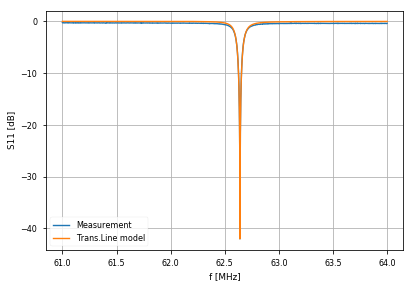

In [17]:
P_in = 20e3 # W

S11dB = []
print(opt_res.x)
L_DUT_opt, Z_DUT_opt, L_CEA_opt, Z_CEA_opt, add_loss_opt = opt_res.x

for f in exp_freq:
    _cfg = T.Configuration(f, P_in, L_DUT_opt, L_CEA_opt, 
                           Z_short_DUT = Z_DUT_opt, Z_short_CEA = Z_CEA_opt, 
                           additional_losses=add_loss_opt)
    S11dB.append(_cfg.S11dB())

fig,ax=plt.subplots()
ax.plot(exp_freq/1e6, exp_mag_dB)
ax.plot(exp_freq/1e6, S11dB)
ax.legend(('Measurement', 'Trans.Line model'))
plt.grid(True)
ax.set_xlabel('f [MHz]')
ax.set_ylabel('S11 [dB]')

[ 0.03309784  0.0034455   0.03238703  0.00680031  0.95432379]


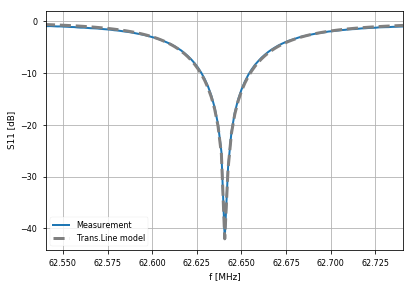

In [18]:
plt.style.use('seaborn-paper')
fig,ax=plt.subplots()
ax.plot(exp_freq/1e6, exp_mag_dB, lw=2)
ax.plot(exp_freq/1e6, S11dB, lw=3, color="grey", ls='--')
ax.legend(('Measurement', 'Trans.Line model'))
ax.set_xlim(exp_freq_match/1e6-0.1, exp_freq_match/1e6+0.1)
plt.grid(True)
ax.set_xlabel('f [MHz]')
ax.set_ylabel('S11 [dB]')
print(opt_res.x)

## Voltage and current in the resonator at matching point

Text(0,0.5,'|I| [A]')

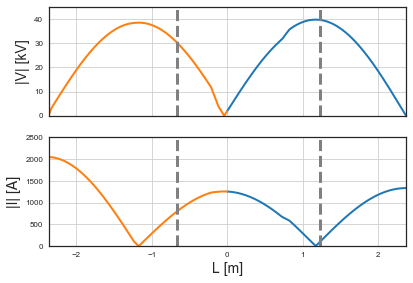

In [19]:
plt.style.use('seaborn-white')

P_in=60e3 # W

cfg_opt = T.Configuration(exp_freq_match, P_in, L_DUT_opt, L_CEA_opt, 
                           Z_short_DUT = Z_DUT_opt, Z_short_CEA = Z_CEA_opt, 
                           additional_losses=add_loss_opt)

# Calculates the voltage and current along the transmission lines
L_CEA, L_DUT, V_CEA, V_DUT, I_CEA, I_DUT = cfg_opt.voltage_current();

# Plotting V,I
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(L_CEA, np.abs(V_CEA)/1e3,-L_DUT, np.abs(V_DUT)/1e3,  lw=2)
ax[0].set_ylim(0, 45)
ax[0].grid(True)
ax[0].set_xlim(min(-L_DUT), max(L_CEA))
ax[0].axvline(x=cfg_opt.L_Vprobe_CEA_fromT, ls='--', color='gray', lw=3)
ax[0].axvline(x=-cfg_opt.L_Vprobe_DUT_fromT, ls='--', color='gray', lw=3)
ax[0].set_ylabel('|V| [kV]', fontsize=14)

ax[1].plot(L_CEA, np.abs(I_CEA),-L_DUT, np.abs(I_DUT),  lw=2)
ax[1].set_ylim(0, 2500)
ax[1].grid(True)
ax[1].axvline(x=cfg_opt.L_Vprobe_CEA_fromT, ls='--', color='gray', lw=3)
ax[1].axvline(x=-cfg_opt.L_Vprobe_DUT_fromT, ls='--', color='gray', lw=3)
ax[1].set_xlabel('L [m]', fontsize=14)
ax[1].set_ylabel('|I| [A]', fontsize=14)